In [1]:
import os
import fitsio
import pandas as pd
import numpy as np
from pathlib import Path, PurePath
import matplotlib.pyplot as plt
import sunpy.visualization.colormaps
import matplotlib.colors as colors
from dotenv import load_dotenv
import seaborn as sns
pd.options.mode.chained_assignment = None

load_dotenv()
FS = 16

In [2]:
def get_dist_mat(coords):
    coords_x = coords % 4096
    coords_y = coords // 4096
    coords_xb = coords_x[:, np.newaxis]
    coords_yb = coords_y[:, np.newaxis]
    dx_broadc = coords_x - coords_xb
    dy_broadc = coords_y - coords_yb
    dist_matrix = dx_broadc**2 + dy_broadc**2
    return dist_matrix

def get_rows_list(array, w1_idx, w2_idx):
    np_mask = (array[:, w1_idx] == 1) & (array[:, w2_idx] == 1)
    df_idx = np.nonzero(np_mask)[0]
    coords = array[np_mask, 0]
    dist_matrix = get_dist_mat(coords)
    select = dist_matrix < 2 
    select2 = np.triu(select, k=1)
    r,c = np.nonzero(select2)
    idx1, idx2 = df_idx[r], df_idx[c]
    return idx1, idx2


def get_df_overlap_counts(df, n_overlaps):
    df_overlap_counts = df.loc[df['overlaps']>=n_overlaps].groupby('GroupNumber')['GroupNumber'].count().rename(f'{n_overlaps}-overlap').to_frame()
    df_overlap_counts['Time'] = gdates.loc[df_overlap_counts.index]
    df_overlap_counts.set_index('Time', inplace=True)
    return df_overlap_counts


def get_2coincidentals(array, w1_idx, w2_idx):
    idx1, idx2 = get_rows_list(array, w1_idx, w2_idx)
    records = [df0.loc[[i1, i2]][['coords', 'int1', 'int2', 'wref']] for i1, i2 in zip(idx1, idx2)]
    df_records = pd.concat(records, keys=list(range(len(records))))
    return df_records


def get_2clusters(array, w1_idx, w2_idx, group_n=None):
    idx1, idx2 = get_rows_list(array, w1_idx, w2_idx)
    # To remove conjugates
#     keep_mask = arr0[idx1, 3] != arr0[idx2, 3] 
#     recordsf = np.concatenate((arr0[idx1[keep_mask], 0:4], arr0[idx2[keep_mask], 0:4]), axis=1)
    
    records = np.concatenate((array[idx1, 0:4], array[idx2, 0:4]), axis=1)
    df_records = pd.DataFrame(records, columns=['coords1', 'int1_before', 'int1_after', 'wref1', 'coords2', 'int2_before', 'int2_after', 'wref2'])
    if group_n is not None:
        df_records['GroupNumber'] = group_n
    
    return df_records


def get_3clusters(array, w1_idx, w2_idx, w3_idx, group_n=None):
    df12 = get_2clusters(array, w1_idx, w2_idx, group_n=group_n)
    df13 = get_2clusters(array, w1_idx, w3_idx, group_n=group_n)
    series123 = df12['coords1'].loc[df12['coords1'].isin(df13['coords1'])]
    return series123




In [3]:
data_dir = os.environ['SPIKESDATA']
spikes_db = pd.read_parquet(os.path.join(data_dir, 'spikes_df_2018.parquet'), engine='pyarrow')
spikes_db.head(8)

Path   Size  \
1  2018/01/01/2018-01-01T00h00m00.57Z_0094.spikes...  46080   
2  2018/01/01/2018-01-01T00h00m02.07Z_0335.spikes...  72000   
3  2018/01/01/2018-01-01T00h00m05.84Z_0193.spikes...  25920   
4  2018/01/01/2018-01-01T00h00m06.58Z_0304.spikes...  77760   
5  2018/01/01/2018-01-01T00h00m08.07Z_0131.spikes...  51840   
6  2018/01/01/2018-01-01T00h00m10.35Z_0171.spikes...  25920   
7  2018/01/01/2018-01-01T00h00m11.08Z_0211.spikes...  43200   
8  2018/01/01/2018-01-01T00h00m12.58Z_0094.spikes...  46080   

                              Time  Wavelength  GroupNumber  
1 2018-01-01 00:00:00.570000+00:00          94            1  
2 2018-01-01 00:00:02.070000+00:00         335            1  
3 2018-01-01 00:00:05.840000+00:00         193            1  
4 2018-01-01 00:00:06.580000+00:00         304            1  
5 2018-01-01 00:00:08.070000+00:00         131            1  
6 2018-01-01 00:00:10.350000+00:00         171            1  
7 2018-01-01 00:00:11.080000+00:00         211            1  
8 2018-01-01 00:00:12.580000+00:00          94            2

### Map the group number to a timestamp. Arbitrary choice: choose the 1st file in the group. 

In [4]:
gdates = spikes_db.groupby('GroupNumber').nth(0)[['GroupNumber', 'Time']]
gdates.set_index('GroupNumber', inplace=True)
gdates.head()

Time
GroupNumber                                 
1           2018-01-01 00:00:00.570000+00:00
2           2018-01-01 00:00:12.580000+00:00
3           2018-01-01 00:00:24.580000+00:00
4           2018-01-01 00:00:36.570000+00:00
5           2018-01-01 00:00:48.570000+00:00

### Load a parquet file (1 day of data). This is the result of the preprocessing that runs through all the individual fits files to only keep those coordinates where at least one nearest neighbour was found in any of the 6 other wavelengths. 

The index (GroupNumber) map to a timestamp. Same GroupNumber are for observations taken at the same time. 

#### columns are: 
- coords:1D coordinates of a 4096 x 4096 image array
- int1, int2: intensity before interpolation, intensity after interpolation
- wref: reference wavelength number of that coordinate (from 0 to 6)
- w0, ... w6: binary (1 or 0) telling whether that coordinate has a nearest neighbour in those wavelengths. 

If for a given coordinate wref = 3, then by definition w3 = 1, and there will be at least one the other wavelength with a True value (1), and that "conjugate" or "neighbour" will be found somehwere further down that list and sharing the same GroupNumber (as it belonged to the same file recorded at the same time). 

In [5]:
parquet_dir = Path(os.environ['SPIKESDATA'], '2018', '01')
columns = ['GroupNumber', 'coords', 'overlaps']
df0 = pd.read_parquet(Path(parquet_dir, 'df_coincidentals_2018_01_01.parquet'), columns=columns, engine='pyarrow')
df0.head()

GroupNumber  coords  overlaps
0            1  149558         2
1            1  205896         2
2            1  209992         2
3            1  239694         2
4            1  348983         2

In [6]:
df0.insert(2, 'x', df0['coords']%4096)
df0.insert(3, 'y', df0['coords']//4096)
df0.head()

GroupNumber  coords     x   y  overlaps
0            1  149558  2102  36         2
1            1  205896  1096  50         2
2            1  209992  1096  51         2
3            1  239694  2126  58         2
4            1  348983   823  85         2

### Out of these data above, we want to collect all blobs of spatially connected pixels with 8-connectivity for a given combination of wavelengths. We don't want to compute and store all of them, but being able to ask for one of the combination. At this stage, intensity is a dimension that is not relevant and not used for now. 

E.g: What are the cluster of coordinates within 1 pixel of each other observed with a given combination of wavelengths
- (w0, w1, w2)
- (w0, w1, w3)
- (w0, w1, w4)
- (w0, w3, w5, w6)
- ...
- {w0, w1, w3, w4, w5, w6, w7}

In [7]:
df_counts_list = [get_df_overlap_counts(df0, n) for n in range(2, 8)]

In [8]:
df_counts = pd.concat(df_counts_list, axis=1)
# Fill the NaN values with zeros
df_counts.fillna(0, inplace=True)
df_counts = df_counts.astype(int)
df_counts.head()

2-overlap  3-overlap  4-overlap  5-overlap  \
Time                                                                           
2018-01-01 00:00:00.570000+00:00       2186         34          0          0   
2018-01-01 00:00:12.580000+00:00       2153         19          0          0   
2018-01-01 00:00:24.580000+00:00       2310         49          0          0   
2018-01-01 00:00:36.570000+00:00       2111         22          0          0   
2018-01-01 00:00:48.570000+00:00       2169         23          0          0   

                                  6-overlap  7-overlap  
Time                                                    
2018-01-01 00:00:00.570000+00:00          0          0  
2018-01-01 00:00:12.580000+00:00          0          0  
2018-01-01 00:00:24.580000+00:00          0          0  
2018-01-01 00:00:36.570000+00:00          0          0  
2018-01-01 00:00:48.570000+00:00          0          0

<Axes: xlabel='Time'>

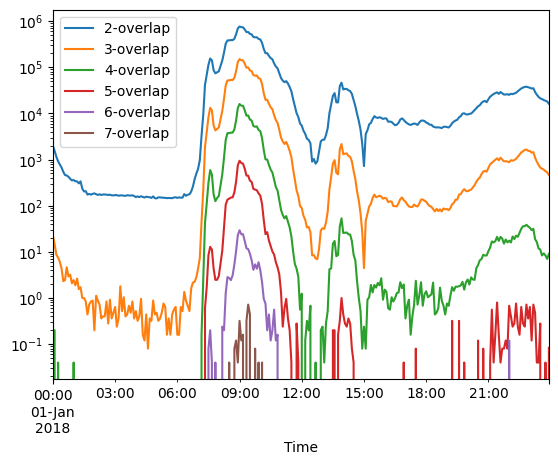

In [9]:
df_counts.resample('5min').mean().plot(y=['2-overlap', '3-overlap', '4-overlap', '5-overlap', '6-overlap', '7-overlap'], kind='line', legend='True', logy=True)

In [10]:
dfs = [df0.copy(),]
for n in range(3,8):
    print('n= ', n)
    new_df=dfs[n-3].loc[dfs[n-3]['overlaps'] >=n].copy()
    dfs.append(new_df)

n=  3
n=  4
n=  5
n=  6
n=  7


In [11]:
for n in range(2, 8):
    dfs[n-2].rename(columns={'overlaps':'min_overlaps'}, inplace=True)
    dfs[n-2]['min_overlaps'].loc[:] = n
    
df_overlaps = pd.concat(dfs).reset_index(drop=True)
df_overlaps.head()

GroupNumber  coords     x   y  min_overlaps
0            1  149558  2102  36             2
1            1  205896  1096  50             2
2            1  209992  1096  51             2
3            1  239694  2126  58             2
4            1  348983   823  85             2

In [12]:
img = fitsio.read(Path(os.environ['SPIKESDATA'], 'images', 'aia.lev1.171A_2018-01-01T00_00_09.35Z.image_lev1.fits'))

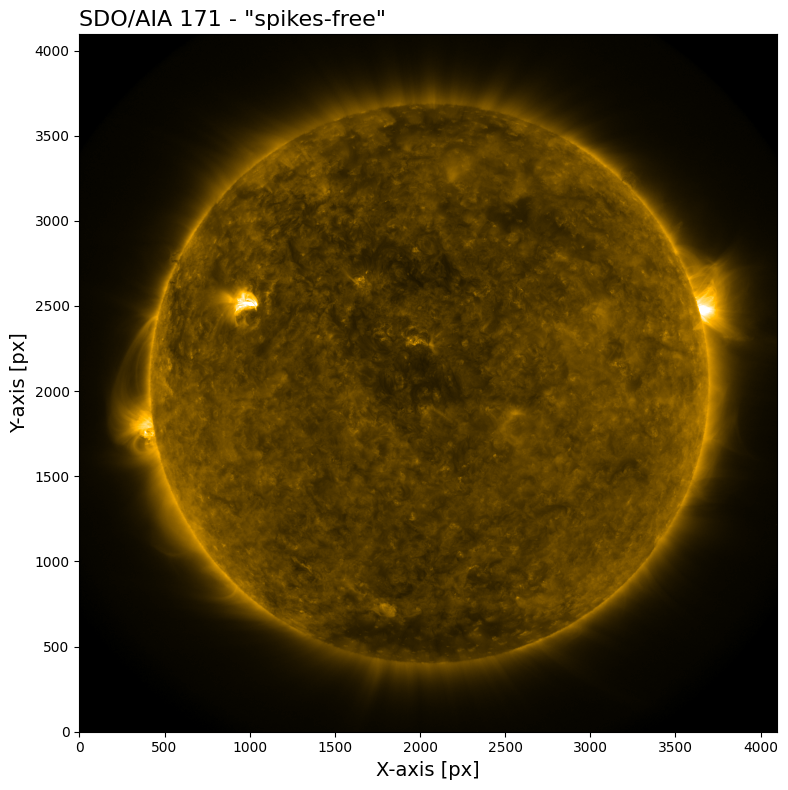

In [13]:
# Image constant and sample FITS image
r_sun = 1578
crpix = 2048.5
nx = 4096
ny = 4096

cmap = plt.get_cmap('sdoaia171')

fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(img, 
           origin='lower', 
           cmap=cmap, 
           norm=colors.PowerNorm(gamma=0.6, vmin=1, vmax=np.percentile(img, 99.98)))

plt.xlim(0, nx-1)
plt.ylim(0, ny-1)
ax.set_xlabel('X-axis [px]', fontsize=FS-2)
ax.set_ylabel('Y-axis [px]', fontsize=FS-2)
ax.set_title('SDO/AIA 171 - "spikes-free"', loc='left', fontsize=FS)

plt.tight_layout()
# plt.savefig('figures/cleaned_image.png', dpi=120)

In [14]:
# Read 1 minutes of raw spikes files
tstart = pd.Timestamp('2018-01-01 00:00:00', tz='UTC')
tend = pd.Timestamp('2018-01-01 04:00:00', tz='UTC')
paths = spikes_db[spikes_db['Wavelength']==171].set_index('Time').loc[tstart:tend]['Path'].apply(
    lambda s:Path(os.environ['SPIKESDATA'], s))
print(paths.head())

spikes = pd.concat([pd.DataFrame(fitsio.read(f).T, columns=['coords', 'int1', 'int2']) for f in paths])
spikes['x'] = spikes['coords'] % 4096
spikes['y'] = spikes['coords'] // 4096
print(spikes.head())

Time
2018-01-01 00:00:10.350000+00:00    /Users/rattie/data/spikes/2018/01/01/2018-01-0...
2018-01-01 00:00:22.350000+00:00    /Users/rattie/data/spikes/2018/01/01/2018-01-0...
2018-01-01 00:00:34.350000+00:00    /Users/rattie/data/spikes/2018/01/01/2018-01-0...
2018-01-01 00:00:46.350000+00:00    /Users/rattie/data/spikes/2018/01/01/2018-01-0...
2018-01-01 00:00:58.350000+00:00    /Users/rattie/data/spikes/2018/01/01/2018-01-0...
Name: Path, dtype: object
   coords  int1  int2     x  y
0    9376    39     4  1184  2
1   11091   282     6  2899  2
2   15057   129     5  2769  3
3   17595   369     4  1211  4
4   19152    50     4  2768  4


In [26]:
groups = gdates[(gdates['Time'] >= tstart) & (gdates['Time'] < tend)].index

overlaps_trange = df_overlaps[['GroupNumber', 'coords', 'x', 'y', 'min_overlaps']].set_index('GroupNumber').loc[groups]
print(overlaps_trange['min_overlaps'].max())
overlaps_trange.head()

4


coords     x   y  min_overlaps
GroupNumber                                
1            149558  2102  36             2
1            205896  1096  50             2
1            209992  1096  51             2
1            239694  2126  58             2
1            348983   823  85             2

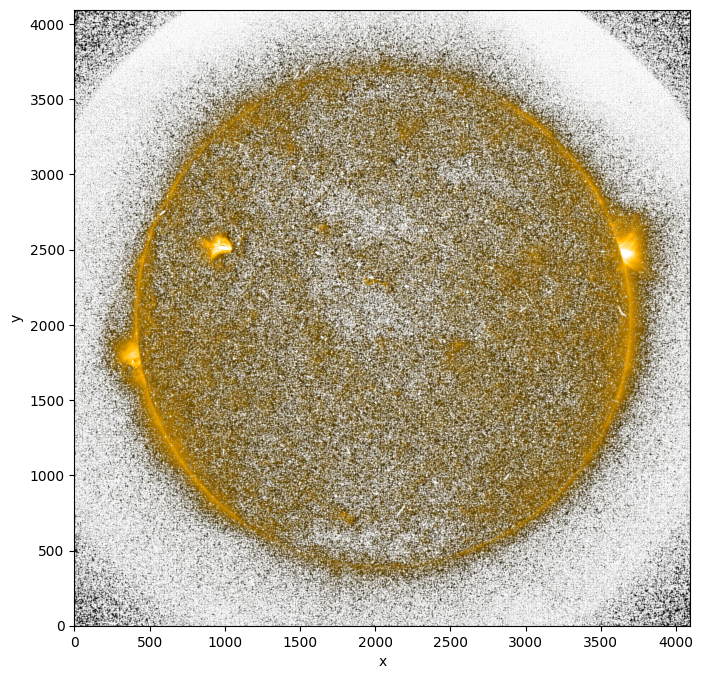

In [30]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=spikes, x='x', y='y', ax=ax, color='white', s=1, alpha=0.2)
plt.xlim([0, 4095])
plt.ylim([0, 4095])

plt.imshow(img, 
           origin='lower', 
           cmap=cmap, 
           norm=colors.PowerNorm(gamma=0.6, vmin=1, vmax=np.percentile(img, 99.98)),
           extent=[0, 4095, 0, 4095])

In [ ]:
# groups = gdates[(gdates['Time'] >= tstart) & (gdates['Time'] < tend)].index
# spikes_w5 = df_overlaps.query('w5==1').set_index('GroupNumber').loc[groups]
# print(spikes_w5['min_overlaps'].max())
# spikes_w5.head()

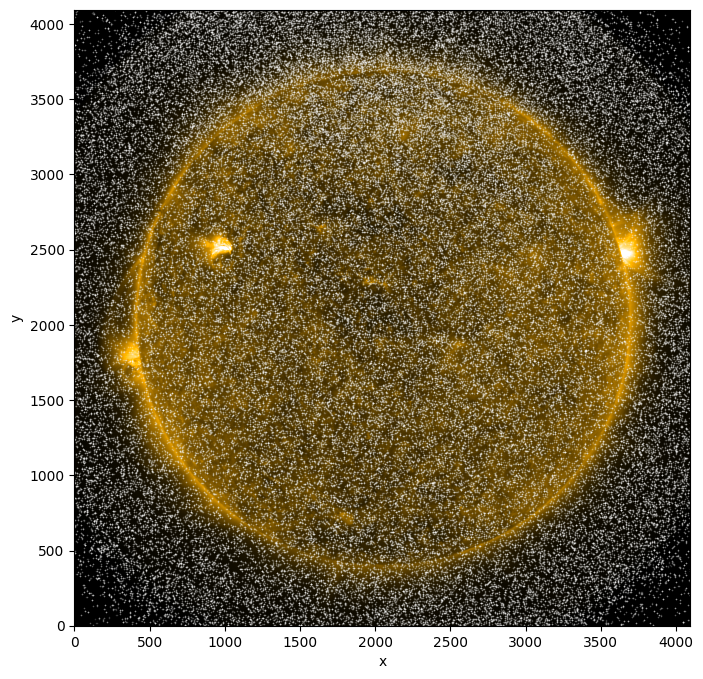

In [31]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=overlaps_trange.drop_duplicates(subset='coords'), x='x', y='y', ax=ax, color='white', s=1, alpha=0.2)
plt.xlim([0, 4095])
plt.ylim([0, 4095])

plt.imshow(img, 
           origin='lower', 
           cmap=cmap, 
           norm=colors.PowerNorm(gamma=0.6, vmin=1, vmax=np.percentile(img, 99.98)),
           extent=[0, 4095, 0, 4095])

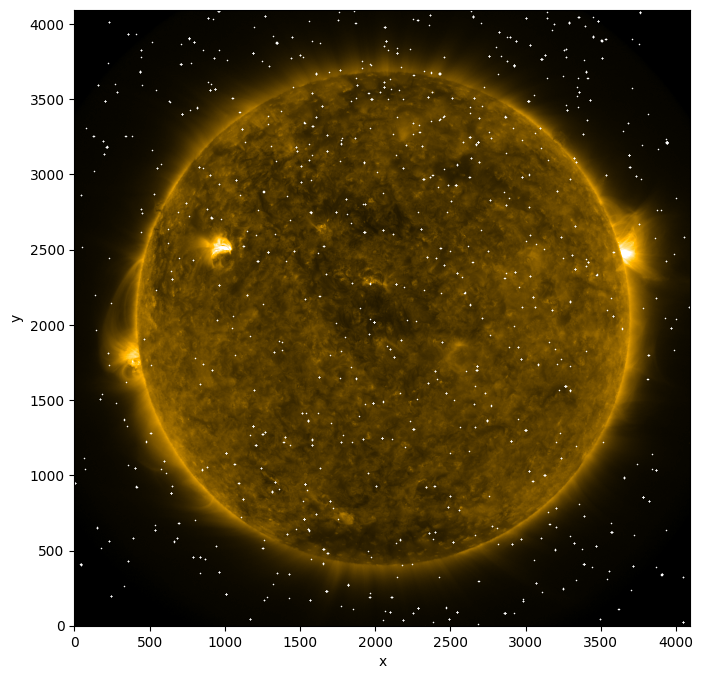

In [34]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=overlaps_trange.query('min_overlaps==3').drop_duplicates(subset='coords'), x='x', y='y', ax=ax, color='white', s=1, alpha=1)
plt.xlim([0, 4095])
plt.ylim([0, 4095])

plt.imshow(img, 
           origin='lower', 
           cmap=cmap, 
           norm=colors.PowerNorm(gamma=0.6, vmin=1, vmax=np.percentile(img, 99.98)),
           extent=[0, 4095, 0, 4095])

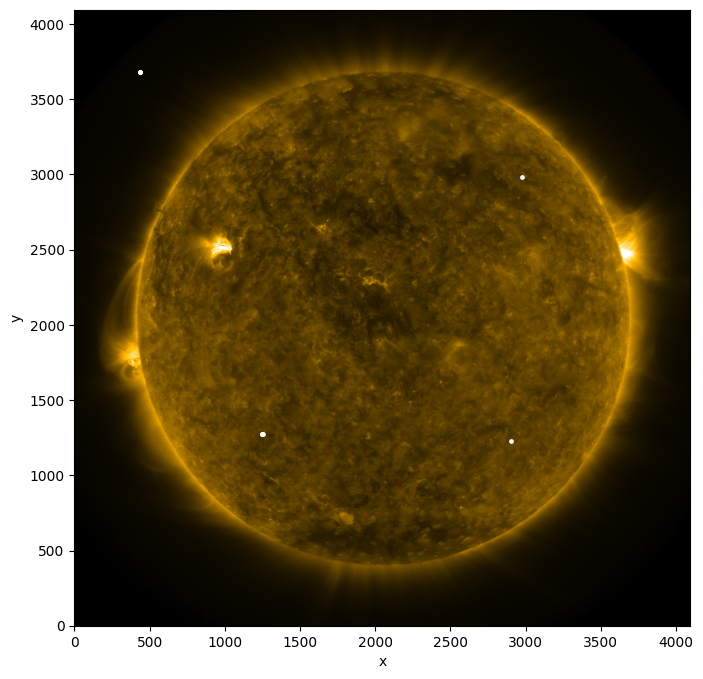

In [36]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=overlaps_trange.query('min_overlaps==4').drop_duplicates(subset='coords'), x='x', y='y', ax=ax, color='white', s=10, alpha=1)
plt.xlim([0, 4095])
plt.ylim([0, 4095])

plt.imshow(img, 
           origin='lower', 
           cmap=cmap, 
           norm=colors.PowerNorm(gamma=0.6, vmin=1, vmax=np.percentile(img, 99.98)),
           extent=[0, 4095, 0, 4095])

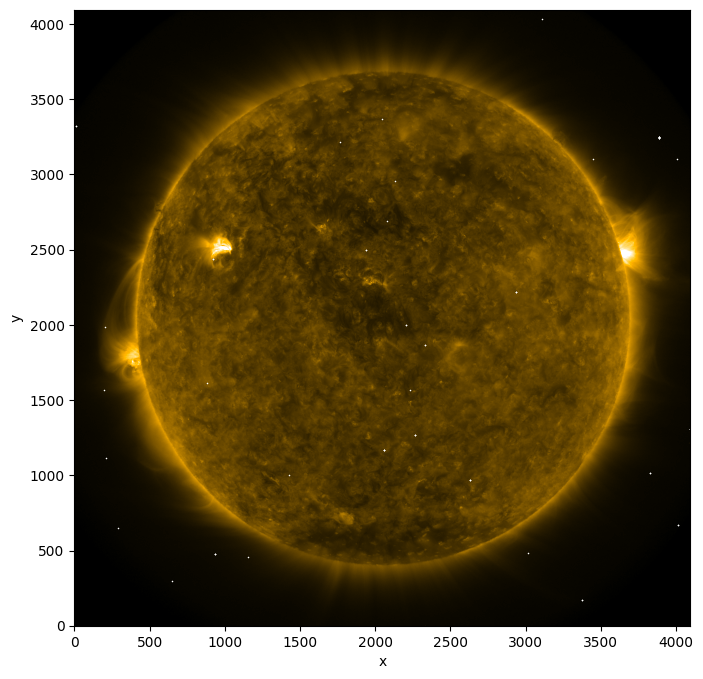

In [41]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=df0.query('overlaps==7'), x='x', y='y', ax=ax, color='white', s=1, alpha=1)
plt.xlim([0, 4095])
plt.ylim([0, 4095])

plt.imshow(img, 
           origin='lower', 
           cmap=cmap, 
           norm=colors.PowerNorm(gamma=0.6, vmin=1, vmax=np.percentile(img, 99.98)),
           extent=[0, 4095, 0, 4095])

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.scatterplot(data=spikes, x='x', y='y', ax=ax, s=1, color='white',
                label='all spikes')


sns.scatterplot(data=spikes_w5, x='x', y='y', 
                hue='min_overlaps',
                size='min_overlaps',
                sizes=(20, 100),
                palette=sns.color_palette(['cyan', 'red']),
                ax=ax)



plt.xlim([0, 4095])
plt.ylim([0, 4095])

plt.imshow(img, 
           origin='lower', 
           cmap=cmap, 
           norm=colors.PowerNorm(gamma=0.6, vmin=1, vmax=np.percentile(img, 99.98)),
           extent=[0, 4095, 0, 4095])

leg = plt.legend(loc='upper right', fancybox=True, framealpha=1, facecolor='black')
texts = ['all spikes', '>= 2 overlaps', '>=3 overlaps']
for i, text in enumerate(leg.get_texts()):
    text.set_color("white")
    text.set_text(texts[i])

In [ ]:
import matplotlib.lines as mlines

fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(img, 
           origin='lower', 
           cmap=cmap, 
           norm=colors.PowerNorm(gamma=0.6, vmin=1, vmax=np.percentile(img, 99.98)), 
           zorder=0)

plt.xlim(0, nx-1)
plt.ylim(0, ny-1)
ax.set_xlabel('X-axis [px]', fontsize=FS-2)
ax.set_ylabel('Y-axis [px]', fontsize=FS-2)
ax.set_title('SDO/AIA 171 ', loc='left', fontsize=FS)

# # Overlay spikes
plt.scatter(spikes['x'], spikes['y'], s=0.5, facecolors='white', edgecolors='white', label='all spikes', alpha=0.5, zorder=1)

plt.scatter(spikes_slice['x'], spikes_slice['y'], s=40, lw=2, facecolors='none', edgecolors='r', label='>=3 overlap', alpha=0.5, zorder=2)

white_circles = mlines.Line2D([], [], color='white', marker='o', linestyle='None',
                          markersize=5, label='all spikes')
red_circles = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markerfacecolor='none',
                          markeredgewidth=2, markersize=10, label='>=3-overlap')

leg = plt.legend(handles=[white_circles, red_circles],
    loc='upper right', fancybox=True, framealpha=1, facecolor='black')


for text in leg.get_texts():
    text.set_color("white")

#     handle._legmarker.set_alpha(1)
# # plt.savefig('figures/overlap_5.png', dpi=120)   


In [ ]:
leg.legend_handles[0]

In [ ]:
coords3 = df0.loc[seriesccount==3]['coords'].values
coords_x3 = coords3 % 4096
coords_y3 = coords3 // 4096

coords5 = df0.loc[seriesccount==5]['coords'].values
coords_x5 = coords5 % 4096
coords_y5 = coords5 // 4096


fig, ax = plt.subplots(figsize=(15,14))
plt.imshow(img, origin='lower', vmin=1, vmax=np.percentile(img, 99.9), 
           cmap=cmap, norm=colors.PowerNorm(gamma=0.6), zorder=0)

ax.set_facecolor('black')
plt.xlim(0, nx-1)
plt.ylim(0, ny-1)
ax.set_aspect(1)
plt.plot(coords_x3, coords_y3, 'w.', ms=2, label='3-wlgth-overlap', zorder=1, alpha=0.1)
plt.plot(coords_x5, coords_y5, 'rd', ms=6, markerfacecolor='none', label='5-wlgth-overlap', zorder=2)
#sdisk = plt.Circle((crpix, crpix), r_sun, color='orange', fill=False, linewidth=2, zorder=2)
#ax.add_artist(sdisk)
#plt.plot(coords_x2, coords_y2, 'b.', ms=6, label='Wave 2')
leg = plt.legend(fontsize=FS, loc='upper right', fancybox=True, framealpha=1, facecolor='black')
for text in leg.get_texts():
    text.set_color("white")
for handle in leg.legendHandles:
    handle._legmarker.set_markersize(6)
    handle._legmarker.set_alpha(1)
    
plt.xlabel('X [px]', fontsize=FS)
plt.ylabel('Y [px]', fontsize=FS)

ax.set_title('SDO/AIA 171 - spikes over 1 day - wavelengths coincidences', loc='left', fontsize=FS+2)


props = dict(boxstyle='round', facecolor='black', alpha=0.8)
ax.text(0.54, 0.065, mycredits, transform=ax.transAxes, fontsize=FS,
        verticalalignment='top', bbox=props, color='white')

plt.tight_layout()
plt.savefig('figures/overlap_3_5.png', dpi=120)

In [ ]:
len(coords3)

### Design method to extract unique coincidental events, lifting any ambiguity (conjugates, redundancies, ...)

In [ ]:
w1_idx = 4
w2_idx = 5
w3_idx = 6
w4_idx = 7

In [ ]:
groups = df0.index.unique()

In [ ]:
events12 = [get_2clusters(df0.loc[group_n].values, w1_idx, w2_idx, group_n) for group_n in groups]
df_events12 = pd.concat(events12)
df_events12 = df_events12.loc[(df_events12.wref2 == 1)]
print(len(events12))
df_events12.head()

In [ ]:
events14 = [get_2clusters(df0.loc[group_n].values, w1_idx, w4_idx, group_n) for group_n in groups]
df_events14 = pd.concat(events14)
df_events14 = df_events14.loc[(df_events14.wref2 == 3)]
df_events14.head()

In [ ]:
c12 = df_events12.groupby('GroupNumber').size().rename('coincidentals count for Wav 0 & Wav 1')
dfcount12 = pd.concat([gdates.loc[groups], c12], axis=1)
dfcount12.set_index('Time', inplace=True)
dfcount12.head()

In [ ]:
%matplotlib inline
ax = dfcount12.plot(figsize=(8,8), fontsize=14)
ax.legend(fontsize=16)

In [ ]:
# gn = groups[0]

# coords1 = df_events12.loc[df_events12['GroupNumber']==gn]['coords1'].values
# coords1 = df_events12['coords1'].values
# coords_x1 = coords1 % 4096
# coords_y1 = coords1 // 4096

# coords2 = df_events12.loc[df_events12['GroupNumber']==gn]['coords2'].values
# coords_x2 = coords2 % 4096
# coords_y2 = coords2 // 4096

In [ ]:
coords1 = df_events12['coords1'].values
coords_x1 = coords1 % 4096
coords_y1 = coords1 // 4096

sdisk = plt.Circle((crpix, crpix), r_sun, color='black', fill=False)
fig, ax = plt.subplots(figsize=(10,10))
plt.xlim(0, nx-1)
plt.ylim(0, ny-1)
ax.set_aspect(1)
ax.add_artist(sdisk)
plt.plot(coords_x1, coords_y1, 'r.', ms=4, markerfacecolor='none', label='Wave 1')
#plt.plot(coords_x2, coords_y2, 'b.', ms=6, label='Wave 2')
plt.legend(fontsize=16, loc='upper right')